In [1]:
import pandas as pd
import numpy as np
import glob, os
from tqdm import tqdm
import _thread
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [2]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, LSTMCell, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

register_matplotlib_converters()

In [3]:
LOAD_MODEL = True
CHECKPOINT_PATH = './b64_m10_ptp6x24x2_samp6x12x24.keras'

DATA_FOLDER = './data/EURUSD/all'
MODULO_MINUTES = 10
PERIOD_TO_PREDICT = 6 * 2 * 24
SAMPLE_PERIOD_PER_INPUT = 6 * 12 * 24

TRAIN_SPLIT = 0.9
BATCH_SIZE = 64
NB_EPOCHS = 20
STEPS_PER_EPOCH = 100

CHECKPOINT_FILENAME = f'b{BATCH_SIZE}_m{MODULO_MINUTES}_ptp2d_samp12d.keras'
TENSORBOARD_DIR = './logs/'

# Prepare Data

In [4]:
def aggregate_data_into_one_frame(data_path):
    all_files = glob.glob(data_path + '*.csv')
    csv_all_content = []

    for filename in all_files:
        temp_df = pd.read_csv(filename, index_col=None, header=None)
        csv_all_content.append(temp_df)

    return pd.concat(csv_all_content, axis=0, ignore_index=True)

def arrange_data(df):
    df.columns = ['Date', 'Time', 'Open', 'Highest', 'Close', 'Lowest', 'NaN']
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    return df

def load_or_process_data(data_folder):
    df = aggregate_data_into_one_frame(f'{data_folder}/')
    arrange_data(df)
    df = df[['Datetime','Open','Highest','Close', 'Lowest']]
    df = df[df.index%MODULO_MINUTES == 0]
    df = df.set_index(['Datetime'])
    return df

In [5]:
df = load_or_process_data(DATA_FOLDER)

In [6]:
df.head()

,Open,Highest,Close,Lowest
Datetime,,,,
2001-01-02 04:17:00,0.9470,0.9470,0.9470,0.9470
2001-01-02 04:27:00,0.9465,0.9465,0.9463,0.9464
2001-01-02 04:38:00,0.9458,0.9458,0.9457,0.9457
2001-01-02 04:50:00,0.9460,0.9461,0.9460,0.9461
2001-01-02 05:00:00,0.9462,0.9462,0.9460,0.9460


In [7]:
len(df)

621410

# Visualise Data

In [8]:
df.head()

,Open,Highest,Close,Lowest
Datetime,,,,
2001-01-02 04:17:00,0.9470,0.9470,0.9470,0.9470
2001-01-02 04:27:00,0.9465,0.9465,0.9463,0.9464
2001-01-02 04:38:00,0.9458,0.9458,0.9457,0.9457
2001-01-02 04:50:00,0.9460,0.9461,0.9460,0.9461
2001-01-02 05:00:00,0.9462,0.9462,0.9460,0.9460


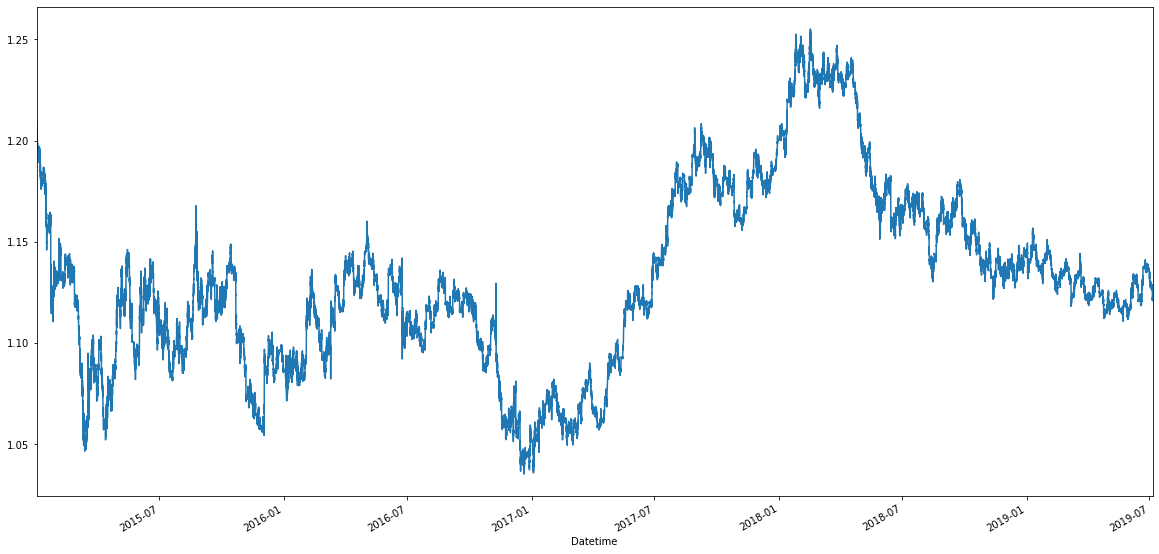

In [9]:
fig, ax = plt.subplots(figsize=(20,10))
df['Close']['2015':'2019'].plot()

# Clean Data

In [10]:
df_clean = df['2001':]
df_clean = df_clean[df_clean['Close'] < 2]
df_clean = df_clean[df_clean['Close'] > 0]
df_clean.head()

,Open,Highest,Close,Lowest
Datetime,,,,
2001-01-02 04:17:00,0.9470,0.9470,0.9470,0.9470
2001-01-02 04:27:00,0.9465,0.9465,0.9463,0.9464
2001-01-02 04:38:00,0.9458,0.9458,0.9457,0.9457
2001-01-02 04:50:00,0.9460,0.9461,0.9460,0.9461
2001-01-02 05:00:00,0.9462,0.9462,0.9460,0.9460


### Add date values as columns

In [11]:
df_clean['Day'] = df_clean.index.dayofyear
df_clean['Hour'] = df_clean.index.hour
df_clean['Minute'] = df_clean.index.minute
df_clean.head()

,Open,Highest,Close,Lowest,Day,Hour,Minute
Datetime,,,,,,,
2001-01-02 04:17:00,0.9470,0.9470,0.9470,0.9470,2,4,17
2001-01-02 04:27:00,0.9465,0.9465,0.9463,0.9464,2,4,27
2001-01-02 04:38:00,0.9458,0.9458,0.9457,0.9457,2,4,38
2001-01-02 04:50:00,0.9460,0.9461,0.9460,0.9461,2,4,50
2001-01-02 05:00:00,0.9462,0.9462,0.9460,0.9460,2,5,0


### Target Data

In [12]:
target = 'Open'
shift_steps = PERIOD_TO_PREDICT

In [13]:
df_target = df_clean[[target]].shift(-shift_steps)
df_target.head()

,Open
Datetime,
2001-01-02 04:17:00,0.9486
2001-01-02 04:27:00,0.9487
2001-01-02 04:38:00,0.9494
2001-01-02 04:50:00,0.9512
2001-01-02 05:00:00,0.9510


# Process data for RNN

In [14]:
x_data = df_clean.to_numpy()[:-shift_steps]
y_data = df_target.to_numpy()[:-shift_steps]
print("Shape:", x_data.shape)
print("Shape:", y_data.shape)

Shape: (621122, 7)
Shape: (621122, 1)


In [15]:
y_data

array([[0.9486 ],
       [0.9487 ],
       [0.9494 ],
       ...,
       [1.12272],
       [1.12271],
       [1.1227 ]])

In [16]:
num_data = len(x_data)
num_train = int(TRAIN_SPLIT * num_data)
print(num_train)
num_test = num_data - num_train
print(num_test)

559009
62113


In [17]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

621122

In [18]:
x_test

array([[  1.16399,   1.1642 ,   1.16394, ..., 304.     ,   9.     ,
         26.     ],
       [  1.16386,   1.16395,   1.16377, ..., 304.     ,   9.     ,
         36.     ],
       [  1.1636 ,   1.16401,   1.1636 , ..., 304.     ,   9.     ,
         46.     ],
       ...,
       [  1.12775,   1.12778,   1.12775, ..., 184.     ,  16.     ,
         24.     ],
       [  1.12769,   1.12771,   1.12767, ..., 184.     ,  16.     ,
         34.     ],
       [  1.12764,   1.12767,   1.12763, ..., 184.     ,  16.     ,
         44.     ]])

In [19]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

621122

In [20]:
num_x_signals = x_data.shape[1]
num_x_signals

7

In [21]:
num_y_signals = y_data.shape[1]
num_y_signals

1

In [22]:
x_train[0]

array([ 0.947,  0.947,  0.947,  0.947,  2.   ,  4.   , 17.   ])

## Normalize

In [23]:
len(y_test)

62113

In [24]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 0.0
Max: 366.0


In [25]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)

print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

Min: 0.0
Max: 1.0000000000000002


In [26]:
x_train_scaled

array([[0.14520548, 0.14518654, 0.14548539, ..., 0.00273973, 0.17391304,
        0.28813559],
       [0.14455316, 0.14453431, 0.14457203, ..., 0.00273973, 0.17391304,
        0.45762712],
       [0.14363992, 0.14362118, 0.14378914, ..., 0.00273973, 0.17391304,
        0.6440678 ],
       ...,
       [0.4272407 , 0.42741978, 0.42755741, ..., 0.83013699, 0.34782609,
        0.94915254],
       [0.42768428, 0.42790243, 0.42800104, ..., 0.83013699, 0.39130435,
        0.10169492],
       [0.4278017 , 0.42792852, 0.42804019, ..., 0.83013699, 0.39130435,
        0.27118644]])

## Batch Generator

In [27]:
def batch_generator(batch_size, sequence_length, train = True):
    """
    Generator function for creating random batches of training-data.
    """
    
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, PERIOD_TO_PREDICT, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            if train:
                idx = np.random.randint(num_train - sequence_length)

                predict_idx = (idx + sequence_length) - PERIOD_TO_PREDICT

                # Copy the sequences of data starting at this index.
                x_batch[i] = x_train_scaled[idx:idx+sequence_length]
                y_batch[i] = y_train_scaled[predict_idx:idx+sequence_length]
            else:
                idx = np.random.randint(num_test - sequence_length)

                predict_idx = (idx + sequence_length) - PERIOD_TO_PREDICT

                # Copy the sequences of data starting at this index.
                x_batch[i] = x_test_scaled[idx:idx+sequence_length]
                y_batch[i] = y_test_scaled[predict_idx:idx+sequence_length]

        yield (x_batch, y_batch)

In [28]:
generator_train = batch_generator(batch_size=BATCH_SIZE,
                            sequence_length=SAMPLE_PERIOD_PER_INPUT)
generator_test = batch_generator(batch_size=BATCH_SIZE,
                            sequence_length=SAMPLE_PERIOD_PER_INPUT, train = False)

In [29]:
x_batch, y_batch = next(generator_train)
print(x_batch.shape)
print(y_batch.shape)
x_batch, y_batch = next(generator_test)
print(x_batch.shape)
print(y_batch.shape)

(64, 1728, 7)
(64, 288, 1)
(64, 1728, 7)
(64, 288, 1)


# RNN

In [30]:
model = Sequential()
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))
model.add(Dense(num_y_signals, activation='sigmoid'))

W0718 22:03:37.000539 11128 deprecation.py:506] From C:\Users\Bapt_\Anaconda3\envs\Machine Learning\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [31]:
warmup_steps = 50

def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [32]:
optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

W0718 22:03:37.205586 11128 deprecation.py:323] From C:\Users\Bapt_\Anaconda3\envs\Machine Learning\lib\site-packages\tensorflow\python\ops\losses\losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         798720    
_________________________________________________________________
dense (Dense)                (None, None, 1)           513       
Total params: 799,233
Trainable params: 799,233
Non-trainable params: 0
_________________________________________________________________


## Callbacks

In [34]:
callback_checkpoint = ModelCheckpoint(filepath=CHECKPOINT_FILENAME, monitor='val_loss', verbose=1, save_weights_only=True,
                                      save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
callback_tensorboard = TensorBoard(log_dir=TENSORBOARD_DIR, histogram_freq=0, write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=1e-4, patience=0, verbose=1)

callbacks = [callback_early_stopping, callback_checkpoint, callback_tensorboard, callback_reduce_lr]

In [35]:
if LOAD_MODEL:
    model.load_weights(CHECKPOINT_PATH)
else:
    model.fit_generator(generator=generator_train, epochs=NB_EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,
                        validation_data=generator_test, validation_steps=900, callbacks=callbacks)

In [36]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 14s 14s/sample - loss: 7.9082e-05


In [37]:
print("loss (test-set):", result)

loss (test-set): 7.908249972388148e-05


# Visualize prediction

In [77]:
def plot_true_and_predicted_output(start_index, train_data=False, plot_everything=False):
    
    end_index = start_index + SAMPLE_PERIOD_PER_INPUT
    start_pred_index = end_index - PERIOD_TO_PREDICT
    
    if train_data:
        x = np.expand_dims(x_train_scaled[start_index:end_index], axis=0)
        y_true = y_scaler.inverse_transform(y_train_scaled[start_index:end_index])
    else :
        x = np.expand_dims(x_test_scaled[start_index:end_index], axis=0)
        y_true = y_scaler.inverse_transform(y_test_scaled[start_index:end_index])
    
    
    y_pred = model.predict(x)
    print(y_true.shape)
    print(np.mean(np.square(np.squeeze(y_pred) - np.squeeze(y_true))))
    print(loss_mse_warmup(y_pred, y_true[np.newaxis, ...]))
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    x_open = []
    for value in x_scaler.inverse_transform(x[0]):
        x_open.append(value[0])
        
    plt.figure(figsize=(15,5))
    
    if plot_everything:
        plt.plot(x_open, label='x')
        plt.plot(range(20, SAMPLE_PERIOD_PER_INPUT), y_pred_rescaled[20:], label='y_pred')
        plt.plot(y_true, label='y_true')
    else:
        plt.plot(range(0, SAMPLE_PERIOD_PER_INPUT),
                 x_open, label='x')
        plt.plot(range(SAMPLE_PERIOD_PER_INPUT, SAMPLE_PERIOD_PER_INPUT + PERIOD_TO_PREDICT),
                 y_pred_rescaled[SAMPLE_PERIOD_PER_INPUT - PERIOD_TO_PREDICT:SAMPLE_PERIOD_PER_INPUT], label='y_pred')
        plt.plot(range(SAMPLE_PERIOD_PER_INPUT, SAMPLE_PERIOD_PER_INPUT + PERIOD_TO_PREDICT),
                 y_true[start_pred_index:], label='y_true')
    plt.legend()
    plt.show()

(1728, 1)
0.6420637942281098
Tensor("Mean:0", shape=(), dtype=float32)


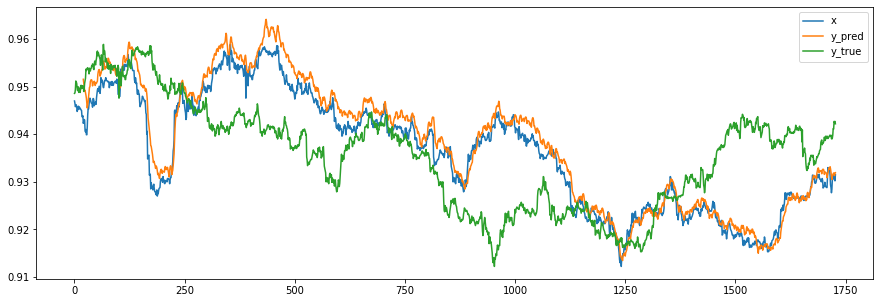

In [78]:
plot_true_and_predicted_output(0, True, True)

ValueError: x and y must have same first dimension, but have shapes (288,) and (0, 1)

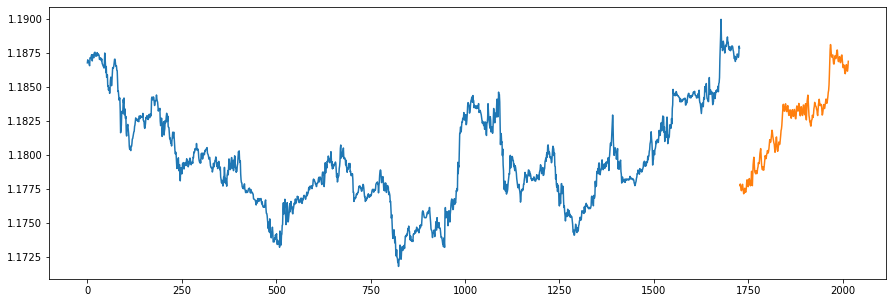

In [40]:
plot_true_and_predicted_output(3500)

In [ ]:
plot_true_and_predicted_output(7000)